In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
import time
from pathlib import Path
import pytesseract
from PIL import Image
from tqdm.autonotebook import tqdm
from functools import reduce
import operator 

def imshow(x):
    fig = plt.figure()
    plt.imshow(x)
    return fig

frames_dir = Path('/home/francesco/Documents/Kanga-Challenge/source/dataset/videos/evo2014/frames/')

/home/francesco/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


## Exploring Traces
Text will usually be present in at least 3/4 frames since it has to be read by humans. We can try to see if we are able to mask it correctly

In [6]:
from data import VideoDataset
from torch.utils.data import DataLoader, random_split

In [7]:
def imread_convert(x):
    x = cv2.imread(str(x))
    if x is not None:
        x = cv2.resize(x, (320, 320))
        x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
    return x

paths = list(frames_dir.glob('*.jpg'))
paths.sort(key=lambda a: int(a.name.split('.')[0]))
frames = list(tqdm(map(imread_convert, paths)))


<IPython.core.display.Javascript object>


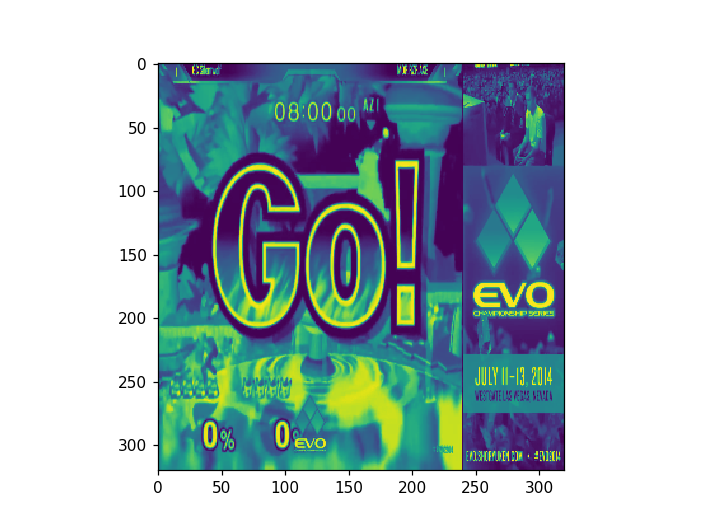

<IPython.core.display.Javascript object>


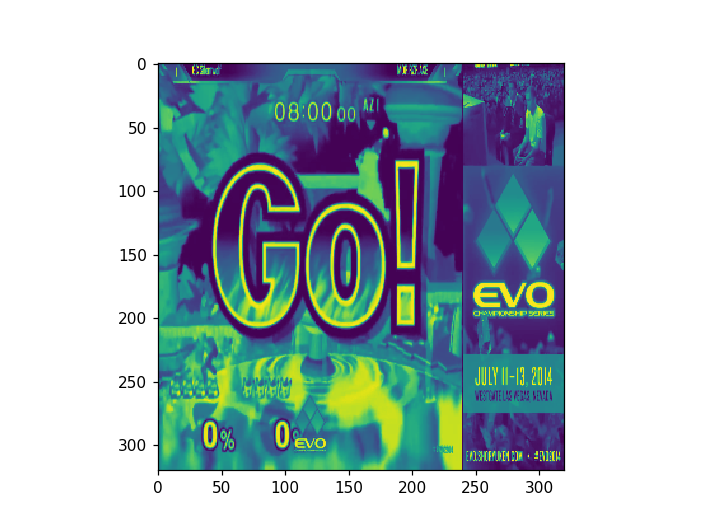

In [49]:
imshow(frames[195])

In [94]:
x = frames[600].astype(np.float) - frames[661].astype(np.float)
mask = np.zeros_like(x)
indices = x[-0.1 < x &  x > 0.1]
mask[indices] = 255
# x[x > 0] = 255
# x[x < 0] = 0
plt.imshow(mask, cmap = 'gray')

SyntaxError: invalid syntax (<ipython-input-94-e00f6f37edbf>, line 3)

## Find text in image
We can use something like this
[EAST: An Efficient and Accurate Scene Text Detector
](https://arxiv.org/abs/1704.03155)
### OpenCV
https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/

In [52]:
from detection import TextDetector

<IPython.core.display.Javascript object>


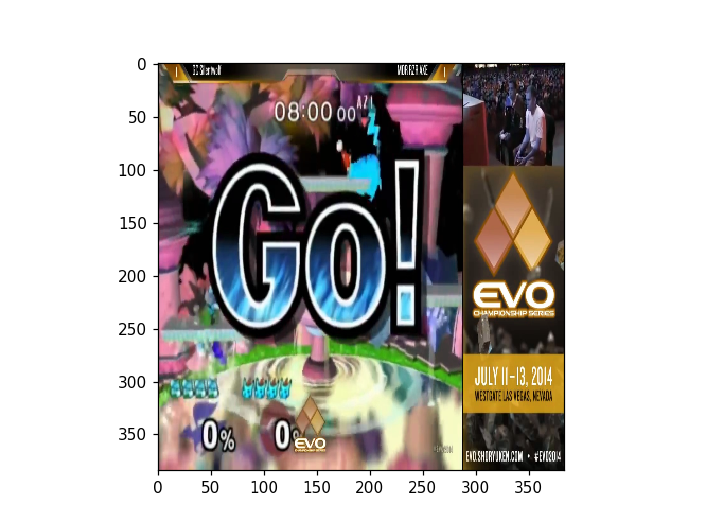

(384, 384, 3)


2019-12-05 22:45:31,059 - [INFO] - Text detection took 0.202084 seconds


In [198]:
file_path =  '/home/francesco/Documents/Kanga-Challenge/source/dataset/videos/evo2014/frames/196.jpg'

img = cv2.imread(file_path)
det = TextDetector()
det([img])

<IPython.core.display.Javascript object>


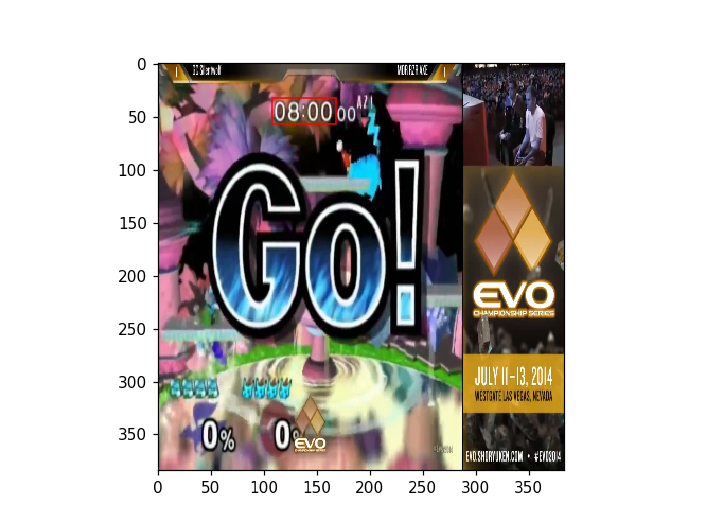

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fefa27aa510>)

In [187]:
det.plot_boxes(img_r)

In [ ]:
from PIL import Image
import pytesseract


print(pytesseract.image_to_string(Image.open(file_path).convert('LA')))

## Yolo


In [172]:
from Project import Project
import torch
from pathlib import Path
from data.transformation import Yolov3Transform
from detection import Yolov3Detector, OCRDetector
from detection.Yolov3Detector import Yolov3Prediction
import cv2
import numpy as np
from torchvision.transforms import Compose, Lambda, ToTensor
import matplotlib.pyplot as plt
from dataclasses import dataclass
import pprint

classes = {0: 'player', 1: 'time', 2: 'stocks', 3: 'damage'}
transform = Compose([
    Yolov3Transform(),
    ToTensor(),
])

detector = Yolov3Detector(weights='./yolov3/weights/best.pt',
                  cfg='./yolov3/cfg/yolov3-tiny-frames.cfg',
                  view_img=True,
                  classes=classes,
                  transform=transform)

root = Project().data_dir / 'videos' / 'evo2014' / 'frames'

img = cv2.imread('./yolov3/data/samples/160.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
preds = detector([img], conf_thres=0.5)
# yolov3_pred = Yolov3Prediction(preds[0])
pprint.pprint(preds)


[tensor([[2.45000e+02, 5.53000e+02, 4.09000e+02, 5.92000e+02, 9.80988e-01, 9.99990e-01, 2.00000e+00],
        [3.70000e+01, 5.49000e+02, 1.93000e+02, 5.95000e+02, 9.71229e-01, 9.99951e-01, 2.00000e+00],
        [1.31000e+02, 6.21000e+02, 1.89000e+02, 6.90000e+02, 9.14900e-01, 9.99973e-01, 3.00000e+00],
        [5.30000e+02, 2.65000e+02, 7.63000e+02, 4.09000e+02, 7.28347e-01, 9.97659e-01, 0.00000e+00],
        [3.81000e+02, 5.40000e+01, 6.34000e+02, 1.16000e+02, 7.26415e-01, 9.99978e-01, 1.00000e+00],
        [6.80000e+01, 1.91000e+02, 1.60000e+02, 2.63000e+02, 6.71860e-01, 8.87411e-01, 3.00000e+00],
        [3.49000e+02, 6.14000e+02, 4.10000e+02, 6.83000e+02, 6.70777e-01, 9.99912e-01, 3.00000e+00]])]


In [166]:
classes

{0: 'player', 1: 'time', 2: 'stocks', 3: 'damage'}

<IPython.core.display.Javascript object>


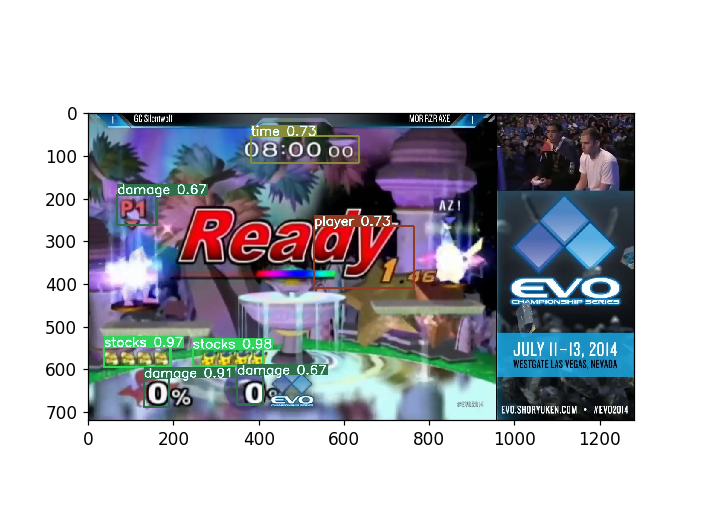

In [170]:
_ = imshow(img)
# _ = imshow(detector.add_bb_on_img(img, preds[0]))

In [196]:
from detection import Detector

@dataclass
class OCRDetector(Detector):
    """
    Easy peasy ocr with tesseract, to improve the prediction you can pass 
    `text_color` to cutoff all values that are not text. 

    TODO: probably there is a cv2 function in which we can define a color and a range.
    """
    text_color: int = 165
    smooth: bool = True # if True apply Gaussian Blur to remove noise
    show_img: bool = False
    transform: callable = None
    config: str = ''
    def detect(self, imgs):
        texts = []
        for img in imgs:
            if self.smooth: 
                img = cv2.GaussianBlur(img, (3,3), 0)
            if self.text_color:
                img = img < self.text_color
#             img = cv2.adaptiveThreshold(img,200,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,5,2)

            if self.transform is not None: img = self.transform(img)
            img = img.astype('uint8')
            if self.show_img : imshow(img)
            x = Image.fromarray(img * 255)
#             x.show()
            text = pytesseract.image_to_string(x, lang='eng', config=self.config)
            texts.append(text)
            
        return texts

<IPython.core.display.Javascript object>


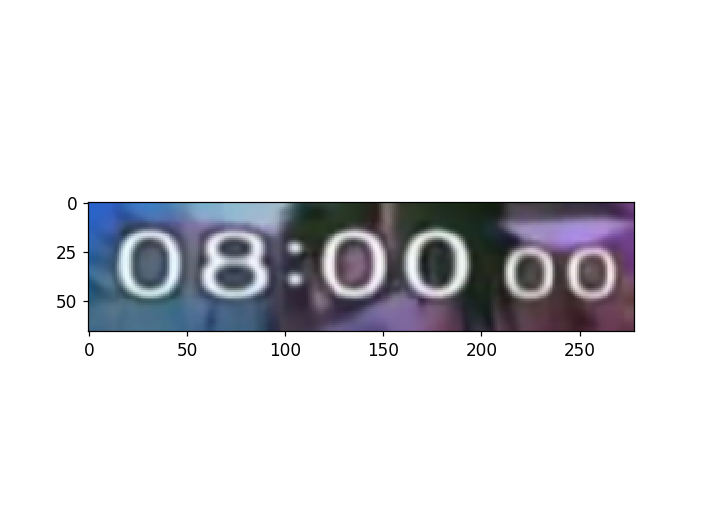

08:00 56-time ['08', '00', '56']


<IPython.core.display.Javascript object>


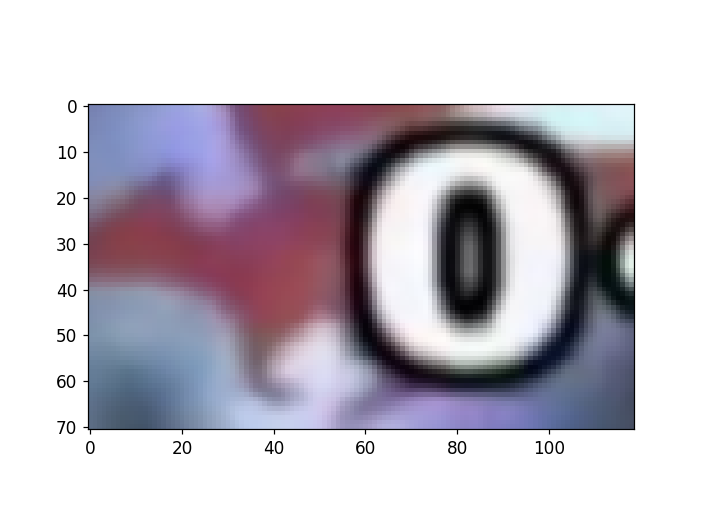

—,0.-damage ['0']


<IPython.core.display.Javascript object>


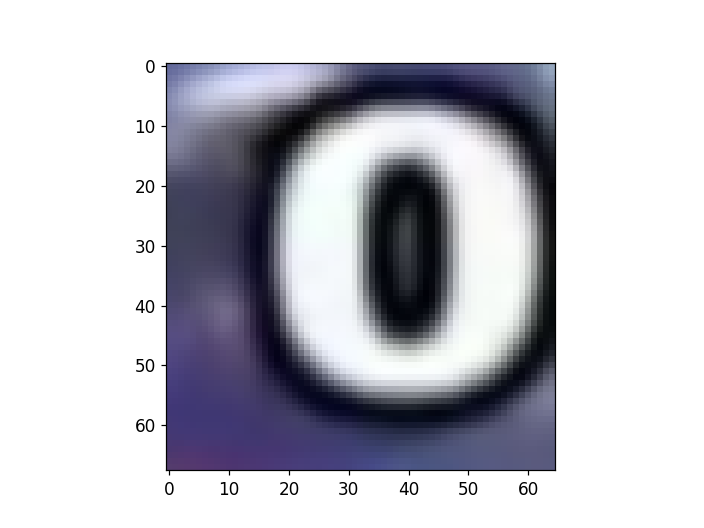

0-damage ['0']


In [197]:
# pred = Yolov3Prediction(preds[0])
import re
# check here https://github.com/tesseract-ocr/tesseract/wiki/ImproveQuality
ocr_detector = OCRDetector(show_img=True, text_color=None, config='--psm 13 --oem 1 -c tessedit_char_whitelist=0123456789')

for crop, cls in pred.cropped_images(img):
        if cls == 3 or cls == 1:
#             crop = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
#             crop=cv2.copyMakeBorder(crop,16,16,16,16,cv2.BORDER_REFLECT)
#             imshow(crop)
#             crop = cv2.resize(crop, (crop.shape[1] * 2, crop.shape[0] * 2))
            text = ocr_detector([crop])[0]
#         replace 'o's with '0's
            text = text.replace('O', '0')
            text = text.replace('o', '0')
            print(text, end='-')
            import re
            text = re.findall(r'\d+', text)
            print(classes[cls], text)
#         elif  cls ==1:
#             crop = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
#             BLACK = [0,0,0]
#             crop=cv2.copyMakeBorder(crop,8,8,8,8,cv2.BORDER_CONSTANT,value=BLACK)
# #             imshow(crop)
#             crop = cv2.resize(crop, (crop.shape[1] * 2, crop.shape[0] * 2))
#             text = ocr_time([crop])
#             print(classes[cls], text)
# #             break
#     